In [1]:
# Example code to run a simulation with various hooks and configurations etc
from symbac.simulation.simulator import Simulator
from config import CellConfig, PhysicsConfig
import colorsys

def generate_color(group_id: int) -> tuple[int, int, int]:
    """
    Generate a unique color based on group_id using HSV color space
    for better visual distinction between cells.
    """
    import colorsys

    # Use golden ratio for better color distribution
    golden_ratio = 0.618033988749895
    hue = (group_id * golden_ratio) % 1.0
    saturation = 0.7 + (group_id % 3) * 0.1  # Vary saturation slightly
    value = 0.8 + (group_id % 2) * 0.2  # Vary brightness slightly

    rgb: tuple[float, float, float] = colorsys.hsv_to_rgb(hue, saturation, value)
    return int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)



In [2]:
physics_config = PhysicsConfig(
    THREADS=2,
    THREADED=True,
    ITERATIONS=260
)


initial_cell_config = CellConfig(
    GRANULARITY=4, # 16 is good for precise division with no gaps, 8 is a good compromise between performance and precision, 3 is for speed
    SEGMENT_RADIUS=15,
    SEGMENT_MASS=1.0,
    GROWTH_RATE=2, # Turning up the growth rate is a good way to speed up the simulation while keeping ITERATIONS high,
    BASE_MAX_LENGTH=45, # This should be stable now!
    MAX_LENGTH_VARIATION=0.24,
    MIN_LENGTH_AFTER_DIVISION=4,
    NOISE_STRENGTH=0.05,
    SEED_CELL_SEGMENTS=30,
    ROTARY_LIMIT_JOINT=True,
    MAX_BEND_ANGLE=0.005,
    STIFFNESS=300_000 , # Common values: (bend angle = 0.005, stiffness = 300_000), you can use np.inf for max stiffness but ideally use np.iinfo(np.int64).max for integer type
    #DAMPED_ROTARY_SPRING=True,  # Enable damped rotary springs, makes cells quite rigid
    #ROTARY_SPRING_STIFFNESS=2000_000, # A good starting point
    #ROTARY_SPRING_DAMPING=200_000, # A good starting point
    PIVOT_JOINT_STIFFNESS=np.inf # This can be lowered from the default np.inf, and the cell will be able to compress
)

simulator = Simulator(physics_config, initial_cell_config)

STEPS = 3000

In [3]:
# Create an object to log the simulation context each frame for plotting later
from tqdm.auto import tqdm
import time
class SimulationLogger:
    def __init__(self):
        # Initialize lists to store simple stats
        self.num_cells = []
        self.t = []

        # Create a tqdm progress bar instance, which we will manually update
        self.pbar = tqdm(total=STEPS, unit="step", desc="Simulation Progress", smoothing =0.0)
        self.last_time = time.time()

        self.frames_to_draw_mpl = []  # Will log the positions of cells at each frame

    # A function to log the number of cells and time at each frame
    def log_frame(self, simulator: 'Simulator') -> None:
        self.num_cells.append(simulator.num_cells)
        if not self.t:
            self.t.append(0)
        else:
            self.t.append(self.t[-1] + simulator.dt)

    # A function to log the time taken for each step
    def get_step_comp_time(self, simulator: 'Simulator') -> None:
        # Don't update the bar every step, only every 20 steps
        update_interval = 20
        if simulator.frame_count % update_interval != 0:
            return
        current_time = time.time()
        # Calculate the time elapsed for this single step
        step_time_ms = (current_time - self.last_time) * 1000 / update_interval  # Convert to milliseconds and average over the last 20 steps
        self.last_time = current_time
        self.pbar.set_postfix(cells=self.num_cells[-1], time_per_step=f"{step_time_ms:.2f}ms")
        # Advance the progress bar by one step
        self.pbar.update(update_interval)

    def log_cell_positions(self, simulator: 'Simulator') -> None:
        # This function can be used to log cell positions if needed
        if simulator.frame_count % 10 != 0:
            current_frame_data = [
                {
                    'position': (seg.body.position.x, seg.body.position.y),
                    'radius': seg.shape.radius,
                    'id': cell.group_id,
                    'color': generate_color(cell.group_id),
                }
                for cell in simulator.cells for seg in cell.PhysicsRepresentation.segments
            ]
            self.frames_to_draw_mpl.append((simulator.frame_count, current_frame_data))

my_logger = SimulationLogger()

simulator.add_post_step_hook(my_logger.log_frame)
simulator.add_post_step_hook(my_logger.get_step_comp_time)
simulator.add_post_step_hook(my_logger.log_cell_positions)

Simulation Progress:   0%|          | 0/3000 [00:00<?, ?step/s]

In [4]:
for step in range(STEPS):
    simulator.step()


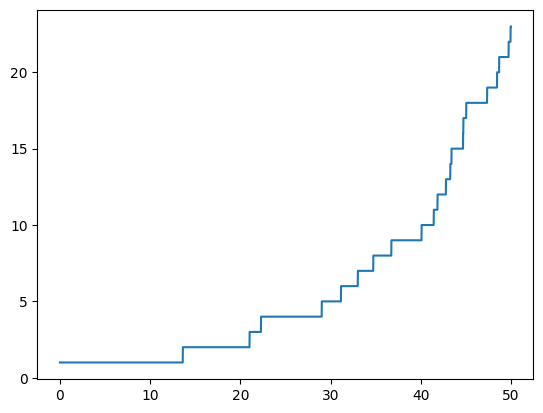

In [5]:
import matplotlib.pyplot as plt
plt.plot(my_logger.t, my_logger.num_cells)
plt.show()

In [6]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import numpy as np

def render_frame(frame_data: list, frame_number: int, output_dir: str):
    """
    Draws a single frame from pre-collected data using Matplotlib and saves it.
    This function is designed to be called in parallel.
    """
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 10))

    if not frame_data:
        ax.set_xlim(-100, 100)
        ax.set_ylim(100, -100)
    else:
        all_positions = np.array([seg['position'] for seg in frame_data])
        min_coords = all_positions.min(axis=0)
        max_coords = all_positions.max(axis=0)
        center = (min_coords + max_coords) / 2
        view_range = (max_coords - min_coords).max() * 1.2 + 200
        ax.set_xlim(center[0] - view_range / 2, center[0] + view_range / 2)
        ax.set_ylim(center[1] + view_range / 2, center[1] - view_range / 2)

    for segment_info in frame_data:
        x, y = segment_info['position']
        r = segment_info['radius']
        rgba_fill_color = np.array(segment_info['color']) / 255.0
        circle = patches.Circle((x, y), radius=r, facecolor=rgba_fill_color)
        ax.add_patch(circle)

    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"Colony State at Frame {frame_number}")
    ax.set_facecolor('black')
    plt.axis('off')
    plt.tight_layout()

    output_path = os.path.join(output_dir, f"frame_{frame_number:05d}.jpg")
    plt.savefig(output_path)
    plt.close(fig)

# Clean output directory
output_directory = "frames"
os.makedirs(output_directory, exist_ok=True)
print(f"Clearing old frames from ./{output_directory}/")
for filename in os.listdir(output_directory):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        os.remove(os.path.join(output_directory, filename))

# --- PARALLEL RENDERING ---
print(f"\nStarting parallel rendering of {len(my_logger.frames_to_draw_mpl)} frames using all available CPU cores...")
start_render_time = time.perf_counter()

# Use joblib to parallelize the rendering of saved frames
# n_jobs=-1 uses all available CPU cores
Parallel(n_jobs=-1)(
    delayed(render_frame)(data, num, output_directory)
    for num, data in tqdm(my_logger.frames_to_draw_mpl, desc="Rendering frames")
)

end_render_time = time.perf_counter()
print(f"Parallel rendering completed in {end_render_time - start_render_time:.2f} seconds.")
print(f"Output frames are saved in the '{output_directory}' directory.")


Clearing old frames from ./frames/

Starting parallel rendering of 2700 frames using all available CPU cores...


Rendering frames:   0%|          | 0/2700 [00:00<?, ?it/s]

Parallel rendering completed in 218.21 seconds.
Output frames are saved in the 'frames' directory.
